# LSTM Example

In this tutorial, we will create a simple recurrent neural network that utilizes Long Short-Term Memory to learn a pattern from sequential data. We will use a dataset that records airline traffic volume per month for a period of several years. 

This example is heavily based on [this excellent tutorial](http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/) by Jason Brownlee. 

## Step 1: Import dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


It is generally a good idea to control the random seed for a program that depends on pseudorandom choices for repeatability. 

In [2]:
np.random.seed(7)

## Step 2: Import dataset and manipulate data
I have already downloaded the dataset to the file "international-airline-passengers.csv". Below is a sample of what this dataset looks like.

In [3]:
!head /Users/f002bpv/Documents/classes/17w/engg177/lstm_tutorial/international-airline-passengers.csv

The data also include a footer at its end, which we will need to remove in processing.

In [4]:
!tail /Users/f002bpv/Documents/classes/17w/engg177/lstm_tutorial/international-airline-passengers.csv

We'll use pandas, a data management tool for python in the style of R, to read in the data and manipulate it. We will only select the second column, and remember to drop the last 3 lines.

In [5]:
df = pd.read_csv("/Users/f002bpv/Documents/classes/17w/engg177/lstm_tutorial/international-airline-passengers.csv",
                usecols=[1], engine='python', skipfooter=3)
dataset = df.values.astype('float32')

Let's see what the data looks like.

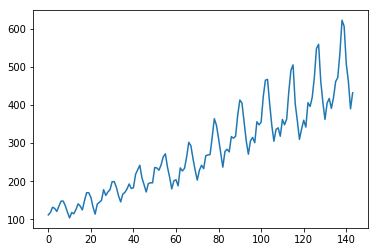

In [6]:
plt.plot(dataset)
plt.show()

The data gradually trends upwards, due to the increase in air travel popularity and availability during its timeframe. It also seems to be roughly periodic by year. 

We will need to normalize this data in order to apply an LSTM RNN. This is because LSTMs are much more sensitive to data scale than flat NNs. The gradients of the lookback nodes can grow or shrink very rapidly during the backpropagation execution. We will normalize this data to (0,1) using a module from scikit-learn, a common toolkit for machine learning.

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

As a sanity check, let's see what the dataset looks like now:

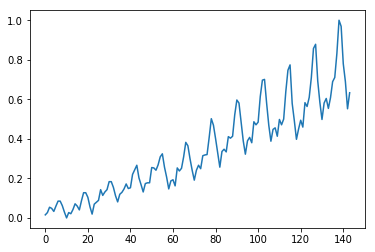

In [8]:
plt.plot(dataset)
plt.show()

As with any other machine learning program, we need to split the data into training and testing sets. Since this data is sequential, we will train on the first two thirds and test on the final third.

In [9]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print("# train samples: %d\n# test samples: %d" %(len(train), len(test)))

# train samples: 96
# test samples: 48


Finally, we need to modify the dataset so that observations include inputs from past time steps in the time series. We'll create a simple function for this, so that we can modify the number of past time steps considered (the *lookback*)

In [10]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

We now create the dataset up to specifications. We will use a lookback=3 for this example.

In [11]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

We now create the appropriate datasets from the train and test sets. Since the data is time series data, we need to phrase the data as a tensor with dimensions (samples, time steps, features).

In [12]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

## Step 3: Define and train the network
We'll use Keras to define a simple LSTM neural network. We'll use a simple array of four hidden LSTM neurons (each of whom accepts *look_back* inputs) and feed that into a single sigmoidally activated node. 

In [13]:
model = Sequential()
model.add(LSTM(4, input_dim=1, activation="tanh"))
model.add(Dense(1, activation=None))
model.compile(loss='mean_squared_error', optimizer='adam')

Now we will train the model using trainX and trainY.

In [14]:
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)

Epoch 1/100
2s - loss: 0.0162
Epoch 2/100
1s - loss: 0.0079
Epoch 3/100
1s - loss: 0.0070
Epoch 4/100
1s - loss: 0.0061
Epoch 5/100
1s - loss: 0.0053
Epoch 6/100
1s - loss: 0.0047
Epoch 7/100
1s - loss: 0.0043
Epoch 8/100
1s - loss: 0.0042
Epoch 9/100
1s - loss: 0.0039
Epoch 10/100
1s - loss: 0.0039
Epoch 11/100
1s - loss: 0.0039
Epoch 12/100
1s - loss: 0.0037
Epoch 13/100
1s - loss: 0.0037
Epoch 14/100
1s - loss: 0.0037
Epoch 15/100
1s - loss: 0.0037
Epoch 16/100
1s - loss: 0.0036
Epoch 17/100
1s - loss: 0.0035
Epoch 18/100
1s - loss: 0.0037
Epoch 19/100
1s - loss: 0.0038
Epoch 20/100
1s - loss: 0.0038
Epoch 21/100
1s - loss: 0.0035
Epoch 22/100
1s - loss: 0.0036
Epoch 23/100
1s - loss: 0.0036
Epoch 24/100
1s - loss: 0.0036
Epoch 25/100
1s - loss: 0.0036
Epoch 26/100
1s - loss: 0.0036
Epoch 27/100
1s - loss: 0.0036
Epoch 28/100
1s - loss: 0.0036
Epoch 29/100
1s - loss: 0.0035
Epoch 30/100
1s - loss: 0.0036
Epoch 31/100
1s - loss: 0.0035
Epoch 32/100
1s - loss: 0.0035
Epoch 33/100
1s -

## Step 4: Evaluate performance
Now that the model is trained, let's examine its performance. We can compute the predicted values on the training and testing sets. 

In [15]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

We should remember that we normalized the functions, so we'll need to invert them back to their original scaling. 

In [16]:
trP = scaler.inverse_transform(trainPredict)
trY = scaler.inverse_transform([trainY])
teP = scaler.inverse_transform(testPredict)
teY = scaler.inverse_transform([testY])

We can examine the train/test performance by simply evaluating the mean squared error.

In [17]:
trainScore = np.sqrt(mean_squared_error(trY[0], trP[:,0]))
testScore = np.sqrt(mean_squared_error(teY[0], teP[:,0]))

In [18]:
print('Train Score: %.2f RMSE\nTest Score: %.2f RMSE' % (trainScore, testScore))

Train Score: 26.87 RMSE
Test Score: 69.59 RMSE


Since the taget values are scalar, we can also plot the model's predictions and visually analyze the model's performance versus the ground truth. 

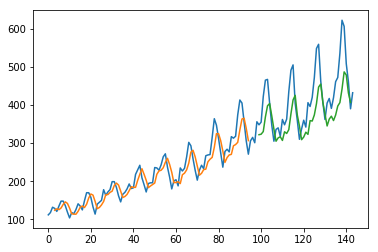

In [19]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trP
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = teP
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()